# revamp of feature importance graph

In [20]:
import os
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
import numpy as np
import glob
import re
import json
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.weightstats import ttest_ind

In [3]:
# importances are stored as Model 1 = best 64 ROI model, Model 2 = best 122 ROI, ... Model 4 = second best 64 ROI model, etc.
dImportances={}
sDir = '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/JournalPaperData/AtlasResolutionComparison8Permutations'
for i in range(15):
    dData = pkl.load(open(os.path.join(sDir, f'RawImportances/Model{i+1}Importances.p'), 'rb'))
    dImportances.update({i:dData})

In [3]:
def fImportancesAndPvals(sRoot):
    def _fP(series, df):
        _,p,_ = ttest_ind(_fGenerateNull(df.drop(series.name, axis=1, inplace=False)), series.values, alternative='smaller')
        return p

    def _fGenerateNull(df):
        """ generates a null distribution of feature importances based on the work from:
            Janitza 2018: A Computationally Fast Variable Importance test for random forests for high-dimensional data
        """
        # flatten all non-nan importance values of 0 or less
        vec=df[df<=0].values[~(np.isnan(df[df<=0].values))].flatten()
        # mirror distribution around 0
        vec=np.concatenate([vec[vec!=0], vec[vec==0],-vec[vec!=0]])
        return vec

    for sFile in glob.glob(os.path.join(sRoot, '*.p')):
        sNewFile=sFile.replace('.p', '_Pvals.csv')
        lsData = []
        if not os.path.isfile(sNewFile):
            # load raw data
            df=pd.DataFrame.from_dict(pkl.load(open(sFile,'rb')))
            # calculate pvals, median, and mean
            df=pd.concat([df.median(axis=0), df.mean(axis=0), df.apply(_fP, axis=0, args=(df,))], axis=1)
            # rename and label columns
            df.columns=['Median Importance', 'Mean Importance', 'One-sided t-test Pval']
            df.insert(0,'Model',int(re.search(r'\d+', sFile.split('/')[-1]).group()))
            # do FDR correction
            for flAlpha in [0.05, 0.01]:
                df.loc[~df['One-sided t-test Pval'].isna(), f'FDR {flAlpha} corrected Pvals'] = fdrcorrection(df['One-sided t-test Pval'].dropna().values, alpha=flAlpha, method='negcorr')[1]
            df.to_csv(sNewFile)
        else:
            df = pd.read_csv(sNewFile, index_col=0)
        lsData.append(df)
    return pd.concat(lsData, axis=1)

In [4]:
pdImportancesAndPvals = fImportancesAndPvals('/project/bioinformatics/DLLab/Cooper/Code/AutismProject/JournalPaperData/AtlasResolutionComparison64Permutations')

In [18]:
# sort into atlases
# below is old mean feature importance
pdData = pd.DataFrame.from_dict(dImportances).transpose()
pdData.insert(0,'Atlas', np.tile([64,122,197],5))

In [ ]:
#below is updated median feature importance across more permutations
pdData = pd.DataFrame.from_dict({i:pdImportancesAndPvals.loc[pdImportancesAndPvals['Model']==i, 'Median Importance'].to_dict() for i in sorted(pdImportancesAndPvals['Model'].unique())}).transpose()
pdData.insert(0,'Atlas', np.tile([64,122,197],5))

In [5]:
pdData

,Site01,Site02,Site03,Site04,Site05,Site06,Site07,Site08,Site09,Site10,...,ROI194-ROI194,ROI194-ROI195,ROI194-ROI196,ROI194-ROI197,ROI195-ROI195,ROI195-ROI196,ROI195-ROI197,ROI196-ROI196,ROI196-ROI197,ROI197-ROI197
0,1.083053e-05,1.161274e-04,1.281613e-04,-0.000400,1.865259e-05,-0.000398,1.213621e-03,1.173308e-04,-0.000020,0.000088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-3.550008e-05,3.008482e-05,2.647464e-05,-0.000033,-2.406785e-06,0.000029,5.776285e-05,1.089070e-04,0.000031,-0.000014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.827973e-05,1.022884e-05,-6.558490e-05,0.000044,6.016963e-07,0.000007,-1.083053e-04,-5.415267e-06,0.000014,-0.000094,...,-0.000017,-0.000033,-0.000010,-0.000004,0.000002,-0.000018,-2.045767e-05,-0.000002,-0.000042,0.000025
3,7.822052e-06,5.174588e-05,1.564410e-05,-0.000107,-9.627141e-06,-0.000195,1.203393e-06,1.016867e-04,-0.000031,0.000174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-6.016963e-07,-4.813570e-06,6.016963e-07,-0.000051,-7.822052e-06,-0.000010,-6.016963e-07,6.016963e-07,0.000000,0.000008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.670347e-05,2.948312e-05,-9.025445e-06,0.000028,1.110223e-16,0.000081,3.128821e-05,-1.624580e-05,-0.000028,-0.000054,...,-0.000001,0.000002,0.000003,0.000007,0.000006,-0.000009,6.016963e-07,0.000010,0.000003,0.000001
6,2.707633e-05,4.392383e-05,-5.956793e-05,-0.000184,1.110223e-16,-0.000573,6.143319e-04,4.639078e-04,0.000007,0.000531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.633062e-05,2.105937e-05,2.767803e-05,-0.000180,-1.110223e-16,-0.000022,-1.052969e-04,-2.406785e-06,-0.000004,-0.000249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.587294e-05,-6.016963e-07,6.197472e-05,0.000011,2.166107e-05,0.000026,-2.406785e-06,-1.504241e-05,-0.000006,-0.000159,...,0.000002,-0.000005,0.000017,0.000009,0.000002,0.000018,3.610178e-06,0.000017,0.000024,0.000004
9,-3.429669e-05,1.582461e-04,-9.025445e-05,-0.000045,-1.744919e-05,-0.000848,-3.122804e-04,3.628229e-04,-0.000173,0.000360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
def fLookupIfExist(dDict, sKey1, sKey2):
    try:
        return dDict[sKey1][sKey2]
    except:
        return f'ROI {sKey2}'

def fRenameROIs(pdData, iAtlas):
    import re
    import json
    # takes ROIx-ROIy string and changes it to named regions
    dLookup = json.load(open('/project/bioinformatics/DLLab/s169682/Code/AutismProject/JournalPaperData/ROICorrespondence.json', 'r'))

    # loop through names and rename if in lookup table
    for sIndex in pdData.index:
        lsDigits=re.findall('\d+', sIndex)
        pdData=pdData.rename(index={sIndex: f'{fLookupIfExist(dLookup,str(iAtlas),str(int(lsDigits[0])-1))} to {fLookupIfExist(dLookup,str(iAtlas),str(int(lsDigits[1])-1))}'})
        pdData=pdData.rename(index={sIndex: sIndex.replace('-', ' to ')})
    return pdData

In [9]:
def fFetchColor(iAtlas):
    dColors={
        'r':list(sns.color_palette("deep"))[3],
        'o':list(sns.color_palette("deep"))[1],
        'y':list(sns.color_palette("deep"))[8],
        'g':list(sns.color_palette("deep"))[2],
        'b':list(sns.color_palette("deep"))[0],
        'v':list(sns.color_palette("deep"))[4]
    }
    lsColors = json.load(open('/project/bioinformatics/DLLab/s169682/Code/AutismProject/JournalPaperData/ROIColor.json', 'r'))[str(iAtlas)]
    return [dColors[x] for x in lsColors]

In [10]:
def fTTest(sCol, iAtlas, dXData, aYData):
    from scipy.stats import ttest_ind

    sID=f"basc{f'{iAtlas}'.zfill(3)}"
    pdASD=dXData[sID].loc[np.squeeze(aYData).astype(bool)]
    pdHC=dXData[sID].loc[~np.squeeze(aYData).astype(bool)]
    
    _, p = ttest_ind(pdASD[sCol].values, pdHC[sCol].values, equal_var=False)
    diff = pdASD[sCol].mean()-pdHC[sCol].mean()
    return p, diff

In [11]:
def fTTestIcon(sCol, iAtlas,dXData, aYData):
    p,diff = fTTest(sCol, iAtlas,dXData, aYData)
    if p>0.05:
        return 'o'
    if diff>0:
        return '+'
    else:
        return '-'

In [69]:
    sData='/project/bioinformatics/DLLab/Cooper/Code/AutismProject/AllDataWithConfounds.p'
    [dXData, aYData] = pkl.load(open(sData, 'rb'))


In [112]:
pdPlot

,cols,vals
0,L. Nucleus Accumbens to L. Posterior Cingulate...,11.944282
1,L. Nucleus Accumbens to L. Posterior Cingulate...,9.599681
2,L. Nucleus Accumbens to L. Posterior Cingulate...,0.932191
3,L. Nucleus Accumbens to L. Posterior Cingulate...,16.708812
4,L. Nucleus Accumbens to L. Posterior Cingulate...,6.219313
...,...,...
70,L. Posterior Cingulate(BA 23) to L. Posterior ...,5.541356
71,L. Posterior Cingulate(BA 23) to L. Posterior ...,2.410513
72,L. Posterior Cingulate(BA 23) to L. Posterior ...,4.576209
73,L. Posterior Cingulate(BA 23) to L. Posterior ...,4.020661


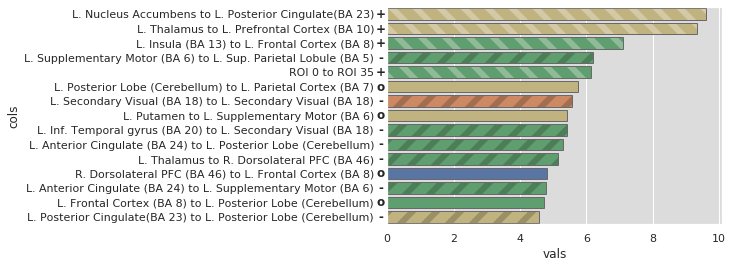

In [144]:
import matplotlib as mpl
mpl.rc('hatch', linewidth=6)
sns.set(rc={'axes.facecolor':'gainsboro'})

sSort='Median'
iAtlas=64
pdAtlas = pdData[pdData['Atlas']==64].transpose().dropna().iloc[1:]
if sSort=='Mean':
    pdAtlas[sSort] = pdAtlas.mean(axis=1)
elif sSort=='Median':
    pdAtlas[sSort] = pdAtlas.median(axis=1)
pdAtlas=pdAtlas/pdAtlas[sSort].std()
pdPlot=pdAtlas.sort_values(by=sSort, ascending=False).filter(like='ROI', axis=0).head(15).iloc[:,:-1].T
# get ttest results
lsIcons = [fTTestIcon(x, iAtlas,dXData, aYData) for x in pdPlot.columns]


#fetch list of colors
lsColors = fFetchColor(iAtlas)

# rename ROIs
pdPlot = fRenameROIs(pdPlot.transpose(), iAtlas).transpose()
fig,ax=plt.subplots()
# plot the horizontal bar graph
pdPlot=pdPlot.melt(var_name='cols', value_name='vals')
pdPlot['cols']=[f'{x} ' for x in pdPlot['cols'].values]
g=sns.barplot(data=pdPlot, y='cols', x='vals', estimator=np.median, palette=lsColors, ci=None, ax=ax)
g.set(xlabel=None)
g.set(ylabel=None)

# add in ttest result labels
for i,p in enumerate(g.patches):
    width = p.get_width()
    ax.text(-pdAtlas[sSort].filter(like='ROI', axis=0).max()*0.019,
            p.get_y()+0.60*p.get_height()-0.075,
            lsIcons[i],
            ha='center', va='center', size=12, weight='bold')
            
# plot light or dark bars:
g_white=sns.barplot(data=pdPlot, y='cols', estimator=np.median, x='vals', edgecolor=(1,1,1,0.3), facecolor=(1,1,1,0), ci=None, ax=ax, hatch='\\', lw=0)
g_white.set(xlabel=None)
g_white.set(ylabel=None)

g_black=sns.barplot(data=pdPlot, y='cols', estimator=np.median, x='vals', edgecolor=(0,0,0,0.2), facecolor=(1,1,1,0), ci=None, ax=ax, hatch='/', lw=0)
g_black.set(xlabel=None)
g_black.set(ylabel=None)

for i,p in enumerate(g_white.patches):
    if 30>i>=15:
        if lsIcons[i-15]!='+':
            p.set_hatch(None)
for i,p in enumerate(g_black.patches):
    if i>=30:
        if lsIcons[i-30]!='-':
            p.set_hatch(None)

# plot outlines on bars
g_white=sns.barplot(data=pdPlot, y='cols', estimator=np.median, x='vals', edgecolor='dimgray', facecolor=(1,1,1,0), ci=None, ax=ax, lw=1)

In [ ]:
    # add in ttest result labels
    for i,p in enumerate(g.patches):
        width = p.get_width()
        ax.text(-pdAtlas[sSort].filter(like='ROI', axis=0).max()*0.012,
                p.get_y()+0.60*p.get_height(),
                lsIcons[i],
                ha='center', va='center', size=12)
        # plot light or dark bar:
    g_white=sns.barplot(data=pdPlot, y='cols', x='vals', color=None, ci=None, ax=ax, edgecolor='k', hatch='//', lw=2)

In [72]:
def fPlot(pdData, iAtlas, ax, dXData, aYData, sSort='Median'):
    # get mean importance per feature, and z-score it
    pdAtlas = pdData[pdData['Atlas']==iAtlas].transpose().dropna().iloc[1:]
    if sSort=='Mean':
        pdAtlas[sSort] = pdAtlas.mean(axis=1)
        fEstimator = np.mean
    elif sSort=='Median':
        pdAtlas[sSort] = pdAtlas.median(axis=1)
        fEstimator = np.median
    pdAtlas=pdAtlas/pdAtlas[sSort].std()
    pdPlot=pdAtlas.sort_values(by=sSort, ascending=False).filter(like='ROI', axis=0).head(15).iloc[:,:-1].T
    
    # get ttest results
    lsIcons = [fTTestIcon(x, iAtlas,dXData, aYData) for x in pdPlot.columns]
    
    # rename ROIs
    pdPlot = fRenameROIs(pdPlot.transpose(), iAtlas).transpose()
    
    #fetch list of colors
    lsColors = fFetchColor(iAtlas)
    
    # plot the horizontal bar graph
    pdPlot=pdPlot.melt(var_name='cols', value_name='vals')
    pdPlot['cols']=[f'{x} ' for x in pdPlot['cols'].values]
    g=sns.barplot(data=pdPlot, y='cols', x='vals', palette=lsColors, ci=None, ax=ax)#capsize=0.1, ci='sd', 
    
    # change limits and labels
    #plt.xlim(0,pdAtlas['Mean'].filter(like='ROI', axis=0).max() + 0.2*pdAtlas['Mean'].filter(like='ROI', axis=0).max())
    g.set(xlabel=None)
    g.set(ylabel=None)
    
    dHatches={
        '+':('\\\\', 'k'),
        '-':('//', 'w'),
        'O':(None, None)
    }

    # add in ttest result labels
    for i,p in enumerate(g.patches):
        width = p.get_width()
        ax.text(-pdAtlas[sSort].filter(like='ROI', axis=0).max()*0.012,
                p.get_y()+0.60*p.get_height(),
                lsIcons[i],
                ha='center', va='center', size=12)
                
    # plot light or dark bar:
    g_white=sns.barplot(data=pdPlot, y='cols', x='vals', color=None, ci=None, ax=ax, edgecolor='k', hatch='//', lw=2)


In [33]:
def fPlotAll(pdData, sSavePath=None, sSort='Median'):
    import matplotlib.transforms as mtrans
    dims = (8, 10)
    fig, ax = plt.subplots(3, figsize=dims)
    
    sData='/project/bioinformatics/DLLab/Cooper/Code/AutismProject/AllDataWithConfounds.p'
    #Dictionary that containes the whole dataset (train and test) in pd dataframe
    [dXData, aYData] = pkl.load(open(sData, 'rb'))
    
    fPlot(pdData, 64, ax[0], dXData, aYData, sSort)
    fPlot(pdData, 122, ax[1],dXData, aYData, sSort)
    fPlot(pdData, 197, ax[2], dXData, aYData, sSort)
    plt.xlabel('Importance: standard deviations from mean importance')
        
    if sSavePath is not None:
        plt.savefig(sSavePath)
    else:
        plt.show()

In [34]:
fPlotAll(pdData)

KeyError: '0'

In [25]:
#fPlotAll('/project/bioinformatics/DLLab/Cooper/Code/AutismProject/JournalPaperData/FeatureImportances.png')